In [1]:
import sri_tabi_problem as sri  # TODO rename to sirlo
import toy_tabi_problem as toy

import pyro
import torch
import pyro.distributions as dist
from chirho.dynamical.ops import State
from collections import OrderedDict
from typing import (
    Union,
)
import matplotlib.pyplot as plt
from pyro.infer.autoguide import AutoNormal

import chirho.contrib.compexp as ep  # TODO rename to expectation_programming (?)

pyro.settings.set(module_local_params=True)

PT = torch.nn.Parameter
TT = torch.Tensor
tt = torch.tensor
UPTT = Union[PT, TT]

assert sri.LOCKDOWN_TYPE == sri.LockdownType.NONCONT_STATE

# Set true just to see if everything runs (a smoke test). Set false to run everything for full count of iterations.
SMOKE = False

In [2]:
def cost(s):
    return 1e1 * toy.cost(d=D, c=C, **s)

### TABI Estimation — Toy Problem

Here, we outline a toy TABI estimation problem, and show vastly improved sample efficiency over a monte-carlo implementation.

In [3]:
# Hyper parameter controlling how far the cost function sits in the tails.
C = tt(1.0)
# Hyper parameter representing a decision parameter. Cost is a function of this parameter.
D = tt(0.5)
# The ground truth for this problem can be seen at this desmos link: https://www.desmos.com/calculator/rjmtzdtbzq
GT = -1.1337

N = 100
M = 500

xx = torch.linspace(-5., 5., 100)

In [4]:
MODEL_DIST = dist.Normal(0., 1.)
def model():
    x = pyro.sample('x', MODEL_DIST)
    return OrderedDict(x=x)

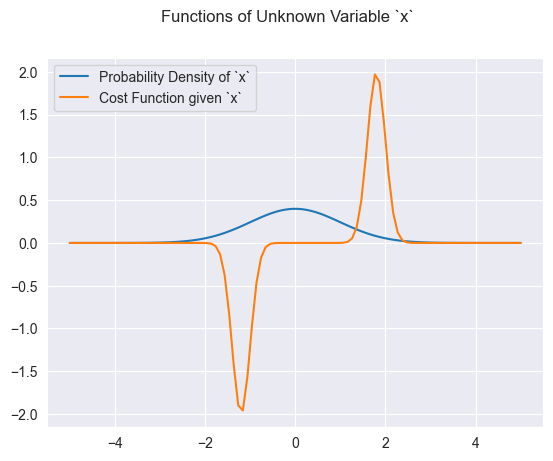

In [5]:
plt.figure()
plt.plot(xx, MODEL_DIST.log_prob(xx).exp(), label="Probability Density of `x`")
plt.plot(xx, toy.cost(d=D, x=xx, c=C), label="Cost Function given `x`")
plt.suptitle("Functions of Unknown Variable `x`")
plt.legend()


In [6]:
expectation_of_cost = ep.E(f=cost, name="cost")
mc_estimates_of_cost = []
for _ in range(M):
    with ep.MonteCarloExpectationHandler(num_samples=N):
        mc_estimates_of_cost.append(
            expectation_of_cost(model)
        )

[<Figure size 640x480 with 2 Axes>,
 <Figure size 640x480 with 2 Axes>,
 <Figure size 640x480 with 2 Axes>]

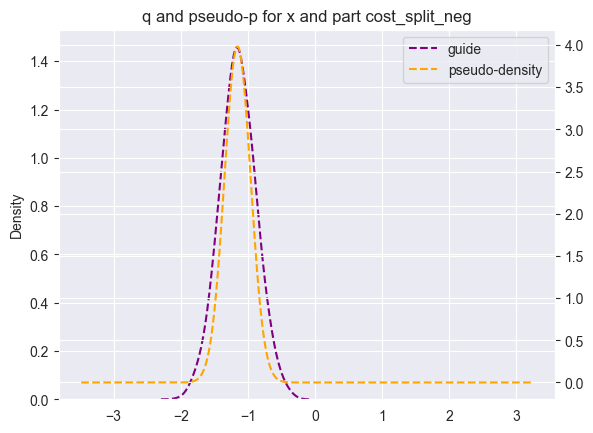

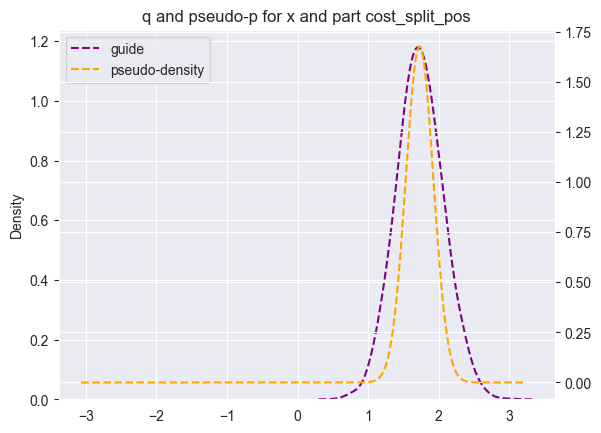

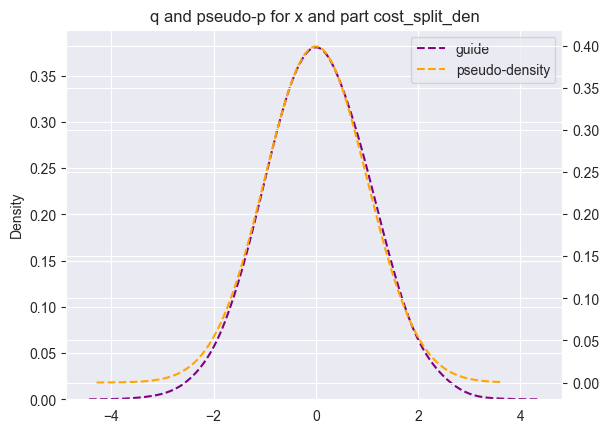

In [7]:
expectation_of_cost_tabi = expectation_of_cost.get_tabi_decomposition()

# TABI reduces to a particular decomposition of the expectation and importance sampling.
iseh = ep.ImportanceSamplingExpectationHandler(num_samples=N)

# Train the TABI proposal distributions.
iseh.register_guides(
    ce=expectation_of_cost_tabi,
    model=model,
    auto_guide=AutoNormal,
    auto_guide_kwargs=dict(init_scale=2.0)
)

# iseh.plot_guide_pseudo_likelihood(
#     rv_name='x',
#     guide_kde_kwargs=dict(bw_method=0.1),
#     pseudo_density_plot_kwargs=dict()
# )

_ = iseh.optimize_guides(
    lr=1e-2,
    n_steps=1000
)

iseh.plot_guide_pseudo_likelihood(
    rv_name='x',
    guide_kde_kwargs=dict(bw_method=0.3, linestyle='--', color='purple'),
    pseudo_density_plot_kwargs=dict(linestyle='--', color='orange'),
    n=3000
)

In [8]:
print(expectation_of_cost_tabi)

((cost_split_pos + (-cost_split_neg)) / cost_split_den)


In [9]:
tabi_estimates_of_cost = []
for _ in range(M):
    with iseh:
        tabi_estimates_of_cost.append(
            expectation_of_cost_tabi(model)
        )

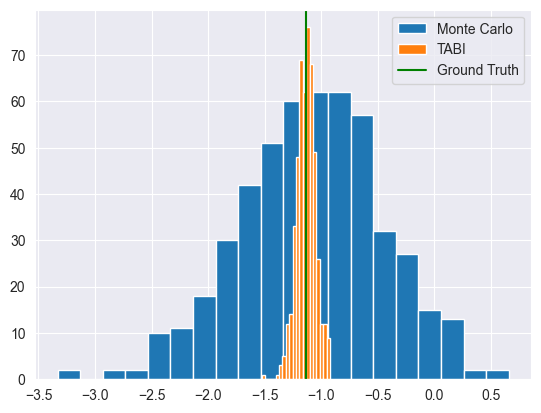

In [16]:
plt.figure()
plt.hist(mc_estimates_of_cost, bins=20, label="Monte Carlo")
plt.hist([v.detach() for v in tabi_estimates_of_cost], bins=20, label="TABI")
plt.axvline(GT, color='green', label="Ground Truth")
plt.legend()